In [1]:
# esta celda controla el estilo del cuaderno
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()

# Vectores de Palabras y Modelos de Lenguaje

## Introducción

Gran parte de los avances recientes en el mundo del Procesamiento del Lenguaje Natural están ligados a mejoras en la forma en la que introducimos y representamos palabras, oraciones y significados dentro de un ordenador. Las máquinas son incapaces de manejar los significados de las palabras ni las relaciones que se establecen entre ellas a menos que seamos capaces de convertir palabras y conceptos en representaciones numéricas con el ordenador pueda operar.

En esta nota técnica profundizaremos en los distintos mecanismos que tenemos para generar y utilizar estas representaciones numéricas, conocidas con el nombre de vectores de palabras o *embeddings*, y aprenderás a utilizar los últimos modelos de lenguaje para hacer que las máquinas manejen significados y conceptos.

## ¿Cómo representamos palabras, oraciones y significados en NLP?

Ya hemos visto en la anterior nota que el primer paso para procesar lenguaje natural es segmentar el texto en unidades. Estas unidades suelen coincidir con la idea intuitiva que tenemos de una palabbra.

Pero cuando hablamos de *palabras*, podemos distinguir dos conceptos diferentes:

- **ocurrencia** (*token*) se refiere a una observación de una palabra en una cadena de texto. 

    Como hemos visto, en algunas lenguas es más o menos complejo identificar los límites de las palabras, pero en la mayoría de las lenguas occidentales y de nuestro entorno se utilizan espacios y otros signos de puntuación para delimitar las palabras.

- **tipo** (*type*) es la representación abstracta de una palabra. Cada **ocurrencia** pertenece a un **tipo** de palabra. 

    Cuando contamos la frecuencia de las palabras de una colección de documentos (o *corpus*), lo que hacemos es contar el número de ocurrencias que tiene cada tipo.
    
Ya hemos visto cómo podemos tokenizar un texto con `spaCy`:

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# instalamos spacy
!pip install -U spacy

# y descargamos un modelo pre-entrenado para inglés
!python -m spacy download en_core_web_md

In [3]:
from typing import List

import spacy


nlp = spacy.load("en_core_web_md")

def tokenize(text: str) -> List[str]:
    """Returns a list of tokens as provided by spaCy"""
    doc = nlp(text)
    return [token.text for token in doc]

In [4]:
textos = [
    """No hubo sorpresa en Bruselas. 621 votos a favor, 49 en contra (los 'remainers' británicos entre ellos) y 13 abstenciones.""",
    """Los senadores interrogan a los jefes de Twitter, Facebook y Google sobre su sesgo político y su permeabilidad a las noticias falsas, en una politizada audiencia a seis días de las elecciones.'""",
    """Los postes de pared ID. Charger para el hogar permiten conectar tu ID.3 para llenar sus baterías al completo durante la noche.""",
]

tweets = [
    """🎉¡#SORTEO! Gana una tostadora YummyToast Double. 🎁 
▪️Síguenos. 
▪️Comenta mencionando a 2 amigos junto a #Cecotec.
Tienes hasta el 9 de febrero para participar. El regalo se sorteará aleatoriamente entre los participantes. ¡Mucha suerte!.""",
    """Jugamos para todos ustedes 🏀‼️🖤 https://t.co/sd12vW93 #MambaMentality""",
]

In [5]:
for text in textos + tweets:
    print(tokenize(text))

['No', 'hubo', 'sorpresa', 'en', 'Bruselas', '.', '621', 'votos', 'a', 'favor', ',', '49', 'en', 'contra', '(', 'los', "'", 'remainers', "'", 'británicos', 'entre', 'ellos', ')', 'y', '13', 'abstenciones', '.']
['Los', 'senadores', 'interrogan', 'a', 'los', 'jefes', 'de', 'Twitter', ',', 'Facebook', 'y', 'Google', 'sobre', 'su', 'sesgo', 'político', 'y', 'su', 'permeabilidad', 'a', 'las', 'noticias', 'falsas', ',', 'en', 'una', 'politizada', 'audiencia', 'a', 'seis', 'días', 'de', 'las', 'elecciones', '.', "'"]
['Los', 'postes', 'de', 'pared', 'ID', '.', 'Charger', 'para', 'el', 'hogar', 'permiten', 'conectar', 'tu', 'ID.3', 'para', 'llenar', 'sus', 'baterías', 'al', 'completo', 'durante', 'la', 'noche', '.']
['🎉', '¡', '#', 'SORTEO', '!', 'Gana', 'una', 'tostadora', 'YummyToast', 'Double', '.', '🎁', '\n', '▪', '️Síguenos', '.', '\n', '▪', '️Comenta', 'mencionando', 'a', '2', 'amigos', 'junto', 'a', '#', 'Cecotec', '.', '\n', 'Tienes', 'hasta', 'el', '9', 'de', 'febrero', 'para', 'part

## Representaciones discretas: cadenas o números enteros

A partir de aquí vamos a asumir que tenemos solucionado el proceso de tokenización e identificación de lo que es una palabra. ¿Cómo continuamos?

La manera más sencilla de representar una palabra es como una cadena, es decir, como una secuencia ordenada de caracteres. Esto es cómodo, pero implica dos cosas:

- La cantidad de memoria que ocupa cada cada palabra varía en función de la longitud :-/

- Comprobar si dos palabras son idénticas es un proceso lento :-(

Así que es habitual utilizar otra opción alternativa que consiste en representar las palabras como números enteros, de manera que a cada palabra se le asigna de manera más o menos arbitraria un número entero positivo.

![](img/words-indexes.jpg)

In [ ]:
!pip install -U scikit-learn
!pip install -U numpy

Podemos ilustrar este proceso de codificación de los tokens como enteros con muy pocas líneas de código. Primero, tokenizamos nuestros tweets:

In [7]:
tweets_tokens = []
tweets_tokens.extend([tokenize(tweet) for tweet in tweets][0])
print(tweets_tokens)

['🎉', '¡', '#', 'SORTEO', '!', 'Gana', 'una', 'tostadora', 'YummyToast', 'Double', '.', '🎁', '\n', '▪', '️Síguenos', '.', '\n', '▪', '️Comenta', 'mencionando', 'a', '2', 'amigos', 'junto', 'a', '#', 'Cecotec', '.', '\n', 'Tienes', 'hasta', 'el', '9', 'de', 'febrero', 'para', 'participar', '.', 'El', 'regalo', 'se', 'sorteará', 'aleatoriamente', 'entre', 'los', 'participantes', '.', '¡', 'Mucha', 'suerte', '!', '.']


Y después creamos una especie de índice para asociar cada token con el entero que lo representa.

In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

tokens_int = label_encoder.fit_transform(tweets_tokens)
token2int = dict(zip(tweets_tokens, tokens_int))

print(token2int)

{'🎉': 39, '¡': 34, '#': 2, 'SORTEO': 11, '!': 1, 'Gana': 9, 'una': 33, 'tostadora': 32, 'YummyToast': 13, 'Double': 7, '.': 3, '🎁': 38, '\n': 0, '▪': 35, '️Síguenos': 37, '️Comenta': 36, 'mencionando': 24, 'a': 14, '2': 4, 'amigos': 16, 'junto': 22, 'Cecotec': 6, 'Tienes': 12, 'hasta': 21, 'el': 18, '9': 5, 'de': 17, 'febrero': 20, 'para': 25, 'participar': 27, 'El': 8, 'regalo': 28, 'se': 29, 'sorteará': 30, 'aleatoriamente': 15, 'entre': 19, 'los': 23, 'participantes': 26, 'Mucha': 10, 'suerte': 31}


Si lo piensas un poco, verás que este tipo de representación tiene varias ventajas e inconvenientes:

- Todos las palabras ocupan la misma cantidad de memoria :-|

- Comprobar si dos cadenas son la misma palabra es rápido :-)

- Estos identificadores arbitrarios no significan nada :-(

- No hay manera de relacionar palabras similares atendiendo a su identificador :-(

## Palabras como vectores *one hot*

Cuando tenemos un mapeo como el anterior entre palabras y enteros, podemos representar cada palabra como un vector *one hot* de $n$ dimensiones, donde $n$ es el tamaño de vocabulario que manejamos. Estos vectores contendrán $0$ en todas sus dimensiones excepto en la posición que coincida con el índice de la palabra en el vocabulario, que contendrá un $1$.

![](img/one-hot-vectors.png)

La conversión de enteros a vectores *one hot* es muy sencilla, y probablemente la has usado alguna vez para codificar datos categóricos.

In [9]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)

tokens_int = tokens_int.reshape(len(tokens_int), 1)
onehot_tokens = onehot_encoder.fit_transform(tokens_int)

for token in ["🎉", "SORTEO", "los"]:
    print(f"""{token} ==> {onehot_tokens[token2int[token]]} """)

🎉 ==> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
SORTEO ==> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 
los ==> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 


Si te fijas, esta representación en realidad no es muy diferente de la anterior que mapeaba palabras como números enteros. Aunque es muy útil en otros contextos, aquí nos enfrentamos con varios problemas: dispersión y espacio requerido para poder almacenar el vocabulario de una colección de documentos mínimamente grande.

Pero el mayor inconveniente de este tipo de representación a la hora de manejar lenguaje natural es la falta de **similitud**. En NLP, hay muchos problemas que queremos resolver y que están relacionados con esta idea de que dos palabras, dos traducciones, dos documentos pueden ser similares. Esto puede parecer trivial para los seres humanos, que no solemos tener dificultades para detectar que dos oraciones, por ejemplo, son similares aunque no compartan vocabulario porque se refieren a lo mismo, o son equivalentes, o hablan de los mismos temas.

Desde el punto de vista algebraico, existe una técnica sencilla para calcular distancias entre vectores y medir el grado de similitud: el **producto escalar**. El producto escalar de dos vectores es tanto mayor cuanto más similares sean. Pero en el caso de estas representaciones *one hot*, como cualquier par de vectores de este tipo son ortogonales, el resultado del producto escalar es siempre $0$.

Por lo tanto, necesitamos otros mecanismos más sofisticados para vectorizar palabras, textos y colecciones de documentos. Prosigamos con nuestro viaje y veamos otro ejemplo con coleciones de documentos.

## Vectorizando colecciones de documentos

Cargamos un famoso dataset que contiene conversaciones en inglés provenientes de grupos de discusión, organizadas por categoría, y elegimos cuatro temáticas dispares.

In [10]:
import numpy as np

from sklearn.datasets import fetch_20newsgroups

categories = ["comp.windows.x", "rec.sport.baseball", "sci.space", "talk.religion.misc"]
remove = ("headers", "footers", "quotes")

newsgroups_train = fetch_20newsgroups(
    subset="train", categories=categories, remove=remove
)

# tenemos más de 2000 documentos diferentes
print(newsgroups_train.filenames.shape)

(2160,)


Convertimos los documentos a vectores de frecuencias. Los vectores resultantes tienen tantas dimensiones como tokens diferentes contenga la colección de documentos procesada.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# los textos son en inglés y en el cálculo de frencuencias vamos a ignorar las stopwords, es decir,
# algunas palabras muy frecuentes (determinantes, preposiciones) pero que no aportan contenido semántico 
vectorizer = CountVectorizer(stop_words="english")
vectors = vectorizer.fit_transform(newsgroups_train.data).todense()
vocab = np.array(vectorizer.get_feature_names())

print(f"dimensiones del vocabulario: {vocab.shape}")
print(f"dimensiones de los vectores: {vectors.shape}") # (documentos, vocabulario)

dimensiones del vocabulario: (27369,)
dimensiones de los vectores: (2160, 27369)


Acabamos de convertir nuestra collección de mensajes original en una gran matriz de datos donde los documentos se representan como vectores de enteros. Cada fila es un documento, cada columna es un elemento del vocabulario, ordenados alfabéticamente. Cada magnitud de una dimensión indica la frecuencia del token en el documento. Pero si reflexionas un poco acerca de cómo se distribuyen las palabras de una lengua, descubrirás que estas representaciones siguen siendo muy dispersas. La mayoría de los documentos contienen solo un subconjunto del vocabulario, por lo que la mayor parte de las dimensiones serán ceros.

## Palabras como Vectores Densos

Como hemos mencionado antes, calcular la **similitud** entre dos pares de palabras, oraciones o documentos es crucial para muchas tareas de NLP.

### ¿Qué significa **similitud**?

La idea de similitud a veces resulta un poco vaga, pero el aspecto más importante es que dos elementos similares lo son porque tienen algún tipo de relación desde el punto de vista del significado, no necesariamente de sinonimia. Que dos palabras sean similares no implica que sean intercambiables en cualquier situación, pero sí que suelen aparecer en los mismos contextos, por ejemplo:

- Dos antónimos (p. ej. *blanco* y *negro*) son similares porque se pueden aplicar a los mismos objetos. 
- Un término general y otro más específico (p. ej. *perro* y *caniche*) son similares porque sus significados se solapan. 
- Una parte constitutiva y el todo al que pertenece (p. ej. *dedo* y *mano*) son similares por los mismos motivos.

Históricamente, ha habido distintos intentos a mano de codificar de manera explícita estas relaciones de similitud. Desde el punto de vista de la Semántica (la parte de la Lingüística que estudia los significados), el ejemplo más famoso es [Wordnet](https://wordnet.princeton.edu/), una base de datos léxica que almacena palabras, sus significados y las relaciones semánticas que se establecen entre ellas de manera jerárquica. En otras partes de la lingüísitica, como en la Sintaxis, se estudia la estructura del lenguaje y agrupa las palabras similares bajo clases de palabras o categorías como *nombre*, *verbo*, *adjetivo*, etc. 

A partir de cualquiera de estas dos vertientes, o más bien, combinando ambas, podemos llegar a la idea de representar una palabra como un vector. No como un vector *one hot*, como hemos visto antes, sino eligiendo la dimensionalidad que mejor se ajuste a nuestros intereses:

- Si tenemos una colección de palabras que pertenezcan a una misma categoría (p. ej., verbos, fruta, o meses del año), podemos codificar esa pertenencia a la clase asignando un valor binario. 

- Para formas de palabras (variaciones morfológicas) que pertenecen a la misma palabra, podemos reservar una dimensión concreta y asignársela como clase. De este modo, *canto*, *cantaba*, *cantado*, *cantaría* y el resto de formas del verbo *cantar* tendrían un $1$, mientras que el resto de palabras tendrían un $0$.

- Podemos codificar como dimensiones otras características formales como el hecho de contener dígitos, letras mayúsculas, etc.

- Podemos codificar las propiedades de los objetos a los que hacen referencia las palabras como dimensiones. Pensemos por ejemplo en el peso o la longitud. Para la palabra *elefante* podríamos codificar su peso como $6000$ y el de *hormiga* como $0.002$.

En la siguiente imagen se representa una posible descripción, hecha a mano, de cinco términos (*cerdo hormiguero*, *negro*,  *gato*, *edredón* y *zombie*) en base a cuatro características o *features*.

![](img/manual-features.jpg)

Los avances de los los últimos años están dirigidos a proponer algoritmos que extraen este tipo de *features* de manera automática, sin intervención humana, a través del procesamiento de ingentes colecciones de textos y el análisis de cada palabra en su contexto de aparición. Es precisamente este contexto de aparición el que permite derivar las relaciones entre palabras.

## Palabras como vectores distribucionales

> “You shall know a word by the company it keeps.”
> — John R. Firth (1957)
>
>“The meaning of a word is its use in the language (…) One cannot guess how a word functions. One has to look at its use, and learn from that.”
>— Ludwig Wittgenstein (1953)

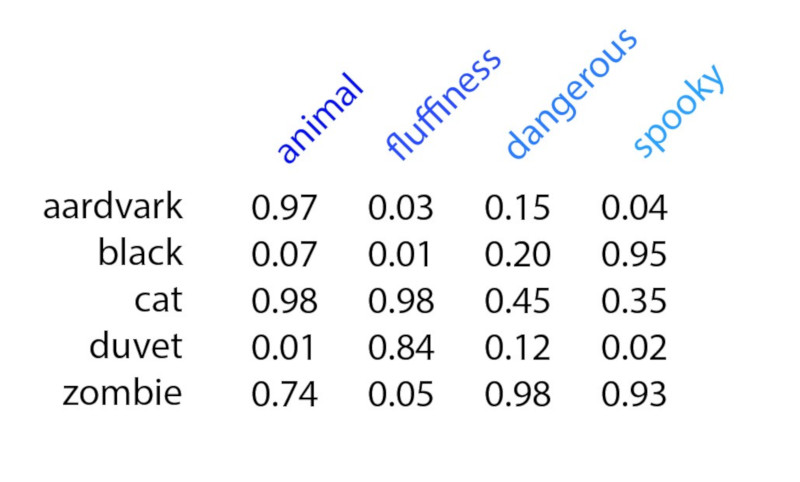

## word2vec: Computing continuous distributed representations of words

En 2013, Mikolov propuso [word2vec](https://code.google.com/archive/p/word2vec/), un algoritmo para aprender embeddings de palabras de manera automática. El proceso consistía en tomar una colección de documentos lo suficientemente grande y representativa de una lengua y aplicar una red neuronal con dos posibles objetivos:

1. tratar de predecir el contexto de aparición a partir de una palabra (**skip-gram**)
2. utilizar el contexto para predecir la palabra en cuestión (**CBOW**: *continuous bag-of-words*)

El resultado final es que el algoritmo aprende a generar vectores de palabras, o *embeddings*, de manera no supervisada: mapeos entre palabras y vectores densos de números reales, que parecen capturar interesantes propiedades lingüísticas, desde el punto de vista semántico y también morfo-sintáctico.

Es muy habitual comparar la similitud entre conceptos calculando el coseno entre los vectores. Dos términos similares tendrán ángulos más cerrados que dos terminos que no lo sean.

![](img/simplistic-term-vector-mode.gif)

También podemos utilizar la analogía con las operaciones aritméticas cuando pensamos en estos estos *embeddings*. Si tomamos el conjunto de componentes semánticos de la palabra *París* y, de alguna manera, le quitamos el significado de *Francia*, pero le sumamos el de *España*, el resultado debería ser algo parecido al contenido semántico de la palabra *Madrid*.

    París - Francia + España ≈ Madrid

    comimos - comer + andar ≈ anduvimos


Podemos acceder a los vectores de palabras de word2vec de varias formas, p. ej., a través de `spaCy`, y calcular distancias de similitud entre distintos términos para comprobar si están alineados con nuestra intuición o no.

In [12]:
# analizamos algunas colocaciones en inglés
token1, _, token2 = nlp("cats and dogs")
token3, _, token4 = nlp("research and development")

print(f"los vectores word2vec de spaCy tienen {token1.vector.shape} dimensiones.\n")

print(f"El grado de similitud entre {token1} y {token2} es {token1.similarity(token2)}")
print(f"El grado de similitud entre {token3} y {token4} es {token3.similarity(token4)}")
print(f"El grado de similitud entre {token1} y {token4} es {token1.similarity(token4)}")

los vectores word2vec de spaCy tienen (300,) dimensiones.

El grado de similitud entre cats y dogs es 0.8311763405799866
El grado de similitud entre research y development es 0.5828717350959778
El grado de similitud entre cats y development es 0.10466640442609787


## GloVe: Global Vectors for Word Representation

En 2014, Pennington del grupo de NLP de la Universidad de Stanford presentó [GloVe](https://nlp.stanford.edu/projects/glove/), otro algoritmo no supervisado para generar representaciones vectoriales de palabras. 

En este caso, el procedimiento consiste en procesar grandes cantidades de muestras de lengua real y extraer relaciones entre palabras atendiendo a la frecuencia con la que cada par de términos co-ocurren en un corpus. 

## fastText: Enriching Word Vectors with Subword Information

word2vec y GloVe tienen un problema: solo crean *embeddings* para las palabras que aparecen de manera explícita en el corpus utilizado para el entrenamiento y, en consecuencia, no generar representaciones para palabras raras o desconocidas. ¿Qué hacemos entonces para manejar las *out-of-vocabulary (OOV) words*? Ha habido varias propuestas, que pasaban por ignorarlas completamente o utilizar un vector neutro, calculado a partir del promedio del resto de *embeddings*

fastText (Bojanowski et al., 2016) describe un método para aprender vectores, no de palabras, sino de subcadenas. Esto nos permite aumentar la cobertura de los tokens representados, de manera que vamos a poder representar palabras poco frecuentes e incluso erratas. Para calcular los vectores de una palabra, el procedimiento consiste en sumar los diferentes *embeddings* de todos sus constituyentes.

Los vectores pre-entrenado de fastText [están disponible en 157 lenguas del mundo](https://fasttext.cc/docs/en/crawl-vectors.html).

# Contextual Word Embeddings

Como hemos visto, algoritmos como word2vec, GloVe o fastText aprenden a calcular de manera no supervisada representaciones continuas de palabras o de segmentos de palabras. Sin embargo, estas representaciones son estáticas y no tienen en cuenta los distintos significados que una misma palabra pueda tener.

Como ya hemos visto, el lenguaje natural está repleto de ambigüedades, a varios niveles, y existen fenómenos como la **polisemia** y la **homografía**, que implican que una misma cadena de caracteres pueda tener más de un significado.

- *banco*: de sentar, de crédito, de peces, de arena
- *cubo*: de agua, operación matemática, figura geométrica
- *planta*: arbusto, fábrica, del pie
- *bajo*: nombre, adjetivo, preposición

¿No sería más lógico asignar diferentes embeddigs teniendo en cuenta los distintos significados?

## ELMo: Embeddings from Language Models

[ELMo](https://allennlp.org/elmo) (Peters et al., 2018) es una nueva técnica del [Allen Institue for AI](https://allennlp.org/) para calcular y asignar vectores de palabras de manera dinámica. ELMo procesa la oración de entrada completa y utiliza dos redes neuronales de tipo LSTM bidireccionales para calcular el *embedding* de cada palabra, atendiendo tanto a su contexto anterior como posterior.

El [entrenamiento de ELMo](https://jalammar.github.io/illustrated-bert/#elmo-context-matters) consiste en entrenar las redes neuronales para predecir cuál es el siguiente token a partir de una determinada secuencia. El **modelo de lenguaje** que aprende a predecir cuál es la siguiente palabra tiene un interesante efecto colateral. El modelo aprende las relaciones lingüísticas de las palabras y las representa como vectores densos que, además: 

- son contextuales, porque la representación que se le asigna a cada palabra viene determinada por su contexto
- son profundas, porque combinan la información de varias capas de una red neuronal de tipo LSTM
- están basadas en caracteres, por lo que pueden manejar más vocabulario

Podemos acceder a estos *embeddings de ELMo* de varias formas, p. ej., a través de `flair`.

In [ ]:
!pip install -U flair
!pip install allennlp==0.9.0
!pip install -U transformers

In [14]:
from flair.data import Sentence
from flair.embeddings import ELMoEmbeddings

# creamos el vectorizador
vectorizer = ELMoEmbeddings("small")

In [15]:
import torch

oracion = Sentence("All results on the paper were fine-tuned on a single Cloud TPU.")
# generamos los emeddings para la oración
vectorizer.embed(oracion)

word_embeddings = torch.stack([token.embedding for token in oracion])
print(f"La oración tokenizada con ELMo tiene {len(oracion)} tokens.")
print(f"Cada token se convierte a un vector de tipo {oracion[0].embedding.shape}.")
print(f"Tensor con los vectores de palabras: {word_embeddings.shape}")

# creamos el embedding de la oración promediando los embeddings de los tokens
embedding = torch.mean(word_embeddings, 0)
print(f"El embedding de la oración es de tipo {embedding.shape}")

La oración tokenizada con ELMo tiene 13 tokens.
Cada token se convierte a un vector de tipo torch.Size([768]).
Tensor con los vectores de palabras: torch.Size([13, 768])
El embedding de la oración es de tipo torch.Size([768])


## BERT: Bidirectional Encoder Representations from Transformers

A finales de 2018, [Google Research presentó BERT](https://github.com/google-research/bert), un modelo de lenguaje basado en la arquitectura de *deep learning* que iba a transformar el mundo del NLP: el [transformer](http://www.peterbloem.nl/blog/transformers). En los meses anteriores se había popularizado un método llamado *Attention* que había tenido mucho impacto en los sistemas de traducción automática. BERT incorpora esta idea para entrenar redes neuronales con mejor rendimiento que con las LSTM.

¿Qué otras características novedosas tiene [BERT](https://github.com/google-research/bert#what-is-bert)?

- Es bidireccional: para generar representaciones de cada palabra se tiene en cuenta tanto el contexto anterior como el posterior. Y no combina dos modelos, uno de izquierda a derecha y otro en sentido contrario. Lo hace de una sola vez.
- Para ello utiliza *masking* en algunos tokens y procesa la oración completa.
- Es capaz de aprender relaciones entre oraciones, porque además de predecir las palabras enmascaradas aprende a predecir las siguiente oración. 

Podemos acceder al modelo pre-entrenado de BERT de varias formas, p. ej., a través de `transformers`.

In [16]:
import torch
from transformers import BertModel, BertTokenizer

MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)

text = "All results on the paper were fine-tuned on a single Cloud TPU."
token_ids = tokenizer.encode(text, add_special_tokens=True)
tokens = tokenizer.convert_ids_to_tokens(token_ids, skip_special_tokens=False)

print(tokens)

['[CLS]', 'All', 'results', 'on', 'the', 'paper', 'were', 'fine', '-', 'tuned', 'on', 'a', 'single', 'Cloud', 'T', '##P', '##U', '.', '[SEP]']


In [17]:
print(f"La oración tokenizada con BERT tiene {len(tokens)} tokens.")

input_ids = torch.tensor([token_ids])
# usamos el último estado para representar los vectores de palabras
with torch.no_grad():
    last_hidden_states = model(input_ids)[0]

# creamos el embedding de la oración promediando los embeddings de los tokens
embedding = torch.mean(last_hidden_states, 1)

print(f"Cada token se convierte a un vector de tipo {last_hidden_states[0][0].shape}.")
print(f"Tensor con los vectores de palabras: {last_hidden_states[0].shape}")
print(f"El embedding de la oración es de tipo {embedding[0].shape}")

La oración tokenizada con BERT tiene 19 tokens.
Cada token se convierte a un vector de tipo torch.Size([768]).
Tensor con los vectores de palabras: torch.Size([19, 768])
El embedding de la oración es de tipo torch.Size([768])


## Conclusiones

En esta tercera nota técnica, hemos profundizado en los distintos mecanismos que tenemos para representar el lenguaje natural utilizando representaciones numéricas, llamadas vectores de palabras o *embeddings*. Hemos hecho un breve recorrido desde las representaciones más simples hasta los modelos de lenguaje más avanzados, y hemos visto cómo utilizar estos modelos ya pre-entrenados con algunas de las librerías de PLN vistas en la nota anterior.